## Clasificación de defectos 

### Se importan las librerías

In [83]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
from skimage import morphology
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.transform import rotate
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import kurtosis
from scipy.stats import skew
import os
import skimage.morphology as morph
import random
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Funciones de Segmentación y Extracción de características

In [0]:
def segment(img): #Función de segmentación
    img_rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Se obtiene cada canal del espacio CMY con una transformación lineal
    #a los canales R, G y B
    img_C = 255 - img_rgb[:,:,0]
    img_M = 255 - img_rgb[:,:,1]
    img_Y = 255 - img_rgb[:,:,2]
    img = img_Y
    h,w = np.shape(img)
    center = (w / 2, h / 2) 
    if (h == 2256): #Rotar la imagen
        img = rotate(img, angle=90,resize=True, order=0)
        img_rgb = rotate(img_rgb, angle=90, resize=True, order=0)
    #bw = closing(img > thresh, square(3))
    #Definir tamaño del kernel
    k_size = 9
    #aplicar filtro de suavizado
    img = cv2.blur(img, (k_size,k_size))
    thresh = threshold_otsu(img) #Threshold automático con el método otsu
    img = img > thresh
    img = morph.remove_small_holes(img,min_size=100) #rellenar espacios pequeños
    label_img = label(img)
    segmented = None
    props = regionprops(label_img)
    for prop in props: #Se evaluan las propiedades para obtener el grano de café
        a = prop.area
        p = prop.perimeter
        redondez = 4*np.pi*a/p**2
        
        label_n = prop.label
        #print("Area: {} Perimetro: {} Redondez: {}".format(a,p,redondez))
        if ((a > 45000) and not(redondez > 0.72 and redondez < 0.78)): #Se ha notado que los cuadrados tienen redondez entre esos rangos
            segmented = label_img == label_n
            print(label_n)
            break    
    #imgplot = plt.imshow(segmented,cmap='gray')
    if(segmented.any() != None):
        img_rgb[:,:,0] = (img_rgb[:,:,0]*segmented)
        img_rgb[:,:,1] = (img_rgb[:,:,1]*segmented)
        img_rgb[:,:,2] = (img_rgb[:,:,2]*segmented)
        #plt.show() 
        return [segmented, img_rgb]
    else:
        return [img_rgb, img_rgb]

def get_moments_hu(props, features):
    moments_hu = props.moments_hu
    moments_hu = np.sign(moments_hu) * np.log(np.abs(moments_hu))
    features['hu0'] = moments_hu[0]
    features['hu1'] = moments_hu[1]
    features['hu2'] = moments_hu[2]
    features['hu3'] = moments_hu[3]
    features['hu4'] = moments_hu[4]
    features['hu5'] = moments_hu[5]
    features['hu6'] = moments_hu[6]
    return features

def get_features_topological(props, features):
    features['euler_num'] = props.euler_number
    return features

def get_features_area(props, features):
    
    features['orientation'] = props.orientation
    features['area_to_convex_ratio'] = props.area/props.convex_area
    features['compacity'] = props.perimeter**2/props.area
    features['roundness'] = 4*np.pi*props.area /(props.perimeter**2)
    #print(i)
    features['area_perimeter_ratio'] = props.area / props.perimeter
    features['elongation'] = props.major_axis_length/props.minor_axis_length
    features['solidity1'] = props.area/props.convex_area
    features['solidity2'] = props.area / props.filled_area
    return features

def get_features(img):
    features = {}
    img *= morphology.remove_small_objects(img.astype(bool), min_size = 20)
    label_img = label(img)
    props = regionprops(label_img)[0]
    features = get_moments_hu(props, features)
    features = get_features_topological(props, features)
    features = get_features_area(props, features)
    return features





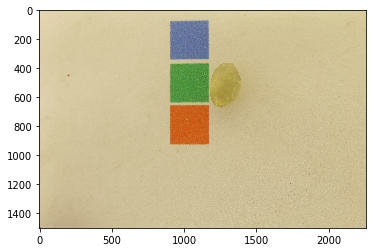

1


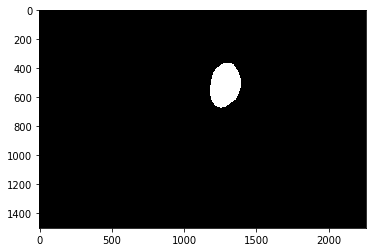

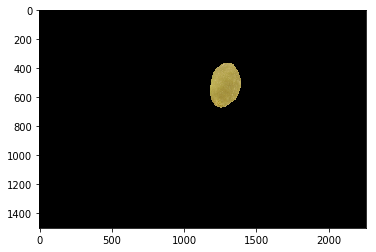

In [0]:
filename = "res/per.jpg"
img = cv2.imread(filename, cv2.IMREAD_COLOR)
img_rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgplt1 = plt.imshow(img_rgb)
plt.show()
results = segment(img) ##Segmentar la imagen
mask = results[0] #Imagen binaria segmentada 
img = results[1] #Imagen original segmentada
#img = img.astype(np.float32)


imgplt = plt.imshow(mask,cmap='gray')
plt.show()

imgplot = plt.imshow(img) 
plt.show()
features = get_features(mask) #Diccionario de características



In [0]:
print(features)

NameError: ignored

### Clasificación

<p>Las clases para la clasificación son de café verde</p>
<ul>
    <li>Arrugado</li>
    <li>Broca</li>
    <li>Mordido</li>
    <li>Bueno</li>
    <li>Malo</li>
</ul>
<p>
    Para la clasificación se requiere armar un data set con las características de cada imagen y clasificadas previamente según su clase, y aplicar para las características topológicas y de forma una selección de características por enfoques estadísticos, y luego para las características de textura la utilización de wrappers
</p>

In [0]:
def filter(form, texture):
    #Explorar que características 
    
def pre_filter():
    path = "CAFE/Clasificar/"
    files = os.listdir(path)
    clasification_dict = {
        "Broca":[],
        "Bien":[],
        "Arrugados":[],
        "Mordido":[],
        "Malos":[]
    }
    for file in files:
        img = cv2.imread(path+file, cv2.IMREAD_COLOR)
        results = segment(img) ##Segmentar la imagen
        mask = results[0] #Imagen binaria segmentada 
        img = results[1] #Imagen original segmentada
        img = img.astype(np.float32)
        form_f = form_features(mask) #Diccionario de características de forma(ingresando solo la máscara)
        texture_f = features_pipeline(img,mask) #Diccionario de características de textura
        place = filter(form_f,texture_f)
        clasification_dict[place].append(file)
    return clasification_dict

#Armar el Data Set

#Crisbos' Area

## Necesario en Colab

In [0]:
from google.colab import files
uploaded = files.upload()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Lectura de datos

In [0]:
#Esta funcion construye rutas para leer las imagenes, lee las imagenes con las rutas,
#llama funciones previamente definidas de segmentacion y extraccion de caracteristicas,
#agrega las caracteristicas "archivo" y "categoria", guarda las caracteristicas en un diccionario 
#y finalmente devuelve todas las tuplas de caracteristicas en una lista de diccionarios

def leerDatosColab(inicio,fin,categoria):
  
  path = "/content/drive/My Drive/9no Semestre/Visión artificial/CAFE/"
  #path = "CAFE/Clasificar/" #Esta otra ruta se usaría si no estuvieramos trabajando en Colab
  #Si ejecutas este codigo y no estas en Colab, usa la otra ruta
  
  if categoria == "Arrugados":
    path += "Arrugados/"
  if categoria == "Broca":
    path += "Broca/"
  if categoria == "Mordido":
    path += "Mordido/"
  
  bigData = [] #Se llena con los diccionarios de datos de cada imagen procesada

  for i in range(inicio, fin+1):
    
    archivo = "IMG_"+str(i)+".JPG" #Construccion del nombre del archivo
    current_img = path + archivo #Construccion de la ruta del archivo completa
    
    try: #Este try se implementa porque algunas imagenes tienen un problema con la segmentacion
      
      img = cv2.imread(current_img, cv2.IMREAD_COLOR) 
      results = segment(img) ##Segmentar la imagen
      mask = results[0] #Imagen binaria segmentada 
      segmented = results[1] #Imagen original segmentada
      features = get_features(mask)#Obtener caracteristicas geometricas de la imagen actual
      features.update({'categoria' : categoria })#add esta caracteristica para posterior uso en red neuronal
      features.update({'archivo' : archivo }) #Add esta otra caracteristica por si es util en algun momento de la vida
      bigData.append(features) #Poner una nueva fila que corresponde a las caracteristicas de una nueva imagen en la lista

    except:
      pass

    
  return bigData


### Lectura de los tres tipos de cafe que clasificaremos

#### lectura de los granos arrugados

In [45]:
data_arrugado = leerDatosColab(5766,5830,"Arrugados") #ARRUGADO -Este es el rango de las imágenes de café arrugado
data_arrugado

1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
2
1
2
1
1
2
1
1
1
1


[{'archivo': 'IMG_5766.JPG',
  'area_perimeter_ratio': 70.32666001563007,
  'area_to_convex_ratio': 0.8978979370816426,
  'categoria': 'Arrugados',
  'compacity': 27.82702731895104,
  'elongation': 1.8598062744288941,
  'euler_num': 1,
  'hu0': -1.5674383067222049,
  'hu1': -4.3252601436274665,
  'hu2': -9.140656019779595,
  'hu3': -11.52748176683692,
  'hu4': -21.94730138197591,
  'hu5': -13.797490333568978,
  'hu6': 22.78539520293877,
  'orientation': -0.010512072462422169,
  'roundness': 0.4515886828414869,
  'solidity1': 0.8978979370816426,
  'solidity2': 1.0},
 {'archivo': 'IMG_5767.JPG',
  'area_perimeter_ratio': 52.57403873413231,
  'area_to_convex_ratio': 0.9653776591163552,
  'categoria': 'Arrugados',
  'compacity': 24.331867229407585,
  'elongation': 1.2994660376497278,
  'euler_num': 1,
  'hu0': -1.7935841156470178,
  'hu1': -6.31137302178033,
  'hu2': -11.405835884167198,
  'hu3': -15.393142409943431,
  'hu4': 29.834265247823755,
  'hu5': -18.56945972967766,
  'hu6': 28.859

#### Lectura de los granos mordidos

In [46]:
data_mordido = leerDatosColab(5532,5655,"Mordido") #Mordido -Este es el rango de las imágenes de café arrugado
data_mordido

2
1
1
5
1
1
1
1
1
1
2
1
2
1
2
1
2
1
2
1
1
1
1
1
1
1
2
1
1
1
2
2
1
2
1
1
1
1
1
2
1
1
1
1
2
2
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2


[{'archivo': 'IMG_5534.JPG',
  'area_perimeter_ratio': 70.12826503629917,
  'area_to_convex_ratio': 0.9781373533486711,
  'categoria': 'Mordido',
  'compacity': 15.647298446826065,
  'elongation': 1.1180944501015224,
  'euler_num': 1,
  'hu0': -1.8181076369497744,
  'hu1': -8.029703299733375,
  'hu2': -9.49756509165211,
  'hu3': -15.932073658647392,
  'hu4': -28.782601624759522,
  'hu5': 20.817683318873897,
  'hu6': -29.36526264775109,
  'orientation': -1.2398593490717682,
  'roundness': 0.803101612528402,
  'solidity1': 0.9781373533486711,
  'solidity2': 1.0},
 {'archivo': 'IMG_5535.JPG',
  'area_perimeter_ratio': 72.19190130562299,
  'area_to_convex_ratio': 0.9875779546722101,
  'categoria': 'Mordido',
  'compacity': 14.949524973604545,
  'elongation': 1.149568313426971,
  'euler_num': 1,
  'hu0': -1.8196806983713707,
  'hu1': -7.593264762944136,
  'hu2': -9.460698110153086,
  'hu3': -15.731947618262566,
  'hu4': 30.575500826780985,
  'hu5': -20.187265046300244,
  'hu6': 28.333887264

#### Lectura de los granos con broca

In [47]:
data_broca = leerDatosColab(5659,5740,"Broca") #Broca -Este es el rango de las imágenes de café arrugado
data_broca

1
1
1
1
1
2
1
2
1
1
1
2
2
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
1
1
1
1
2
1
1
1
2
2
1
1
2
2


[{'archivo': 'IMG_5659.JPG',
  'area_perimeter_ratio': 73.8337412930445,
  'area_to_convex_ratio': 0.8712810260643059,
  'categoria': 'Broca',
  'compacity': 29.819929420930304,
  'elongation': 1.840459976699165,
  'euler_num': 1,
  'hu0': -1.5497847521785408,
  'hu1': -4.316674172979654,
  'hu2': -7.4752850048753805,
  'hu3': -9.426517839386346,
  'hu4': -17.89147337450611,
  'hu5': -11.599190863169502,
  'hu6': -19.67027636130845,
  'orientation': -0.2562917422060838,
  'roundness': 0.42140846267526594,
  'solidity1': 0.8712810260643059,
  'solidity2': 1.0},
 {'archivo': 'IMG_5661.JPG',
  'area_perimeter_ratio': 79.65399144486551,
  'area_to_convex_ratio': 0.9919983586376693,
  'categoria': 'Broca',
  'compacity': 14.478880815868134,
  'elongation': 1.296285637610663,
  'euler_num': 1,
  'hu0': -1.8029366846606452,
  'hu1': -6.348049792713948,
  'hu2': -11.43289082224856,
  'hu3': -16.014259013206672,
  'hu4': -32.61968433521178,
  'hu5': 21.323274049098952,
  'hu6': -29.739406135918

### CREAR EL DATAFRAME PA' EMBUTÍRSELO A LA RED NEURONAL

In [71]:
bigData = data_arrugado + data_mordido# + data_broca #Unimos las tres listas
random.shuffle( bigData ) #Barajamos la big data, por si eso le ayuda a la Red Neuronal
cafe_db_3cat = pd.DataFrame( bigData ) #Convertimos a un dataframe en pandas
cafe_db_3cat.head()

,archivo,area_perimeter_ratio,area_to_convex_ratio,categoria,compacity,elongation,euler_num,hu0,hu1,hu2,hu3,hu4,hu5,hu6,orientation,roundness,solidity1,solidity2
0,IMG_5791.JPG,61.511414,0.961081,Arrugados,18.261184,1.870717,1,-1.637209,-4.450139,-8.942785,-10.970789,-21.128976,-13.807918,21.479559,-1.497564,0.688147,0.961081,1.000000
1,IMG_5801.JPG,59.482968,0.971771,Arrugados,17.911813,1.385246,0,-1.773425,-5.858409,-9.105613,-11.977375,-22.626142,-15.195615,23.341162,1.480682,0.701569,0.971771,0.997089
2,IMG_5592.JPG,63.265905,0.986578,Mordido,15.830310,1.439482,1,-1.761621,-5.628718,-8.656858,-12.199470,-23.653341,-16.808027,-22.696434,-1.507835,0.793817,0.986578,1.000000
3,IMG_5788.JPG,69.344844,0.988482,Arrugados,15.062676,1.212210,1,-1.810886,-6.942136,-9.246890,-14.202103,-25.935455,-17.788652,-27.947775,1.229328,0.834272,0.988482,1.000000
4,IMG_5535.JPG,72.191901,0.987578,Mordido,14.949525,1.149568,1,-1.819681,-7.593265,-9.460698,-15.731948,30.575501,-20.187265,28.333887,1.429397,0.840587,0.987578,1.000000


Separamos las variables de entrada y la variable de salida

In [88]:
X_cafe = cafe_db_3cat.drop('categoria', axis=1)
X_cafe = X_cafe.drop('archivo', axis=1)
y_cafe = cafe_db_3cat['categoria']
y_cafe.head()



0    1
1    1
2    0
3    1
4    0
Name: categoria, dtype: object

In [89]:
#Vamos a reducir estas dos categorías a numeros

lenght = (y_cafe.shape)[0]

for i in range(0,lenght):
  if y_cafe[i] == "Arrugados":
    y_cafe[i] = 1
  if y_cafe[i] == "Mordido":
    y_cafe[i] = 0

y_cafe.head()

0    1
1    1
2    0
3    1
4    0
Name: categoria, dtype: object

Miramos las dimensiones de los datasets para saber cómo hacer la red neuronal

In [90]:
print(cafe_db_3cat.shape)
print(y_cafe.shape)
print(X_cafe.shape)

(117, 18)
(117,)
(117, 16)


**ARQUITECTURA ~ADIVINADA~ PLANTEADA PARA LA RED:**

1. **Entrada de 16 variables (conjunto X, observar X.shape)**

2. **Primer capa oculta (hidden layer) con 38 nodos (neuronas) y función de activación ReLu.**

3. **Segunda capa oculta con 26 nodos y activación ReLu**

4. **Capa de salida con 1 nodo y activación Sigmoide**

In [0]:
#definir el modelo, será secuencial dado que se pondrá un layer tras otro totalmente conectados
model7 = Sequential()
#Capa de entrada y primer capa oculta(ambos se ejecutan con esta instrucción)
model7.add(Dense(38, input_dim=16, activation='relu'))
#Segunda capa oculta
model7.add(Dense(26, activation='relu'))
#Capa de salida
model7.add(Dense(1, activation='sigmoid'))

warnings.filterwarnings('ignore')

In [0]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
warnings.filterwarnings('ignore')

In [94]:
model7.fit(X_cafe, y_cafe, epochs=40, batch_size=3)
warnings.filterwarnings('ignore')

Epoch 1/40
117/117 [==============================] - 1s 6ms/step - loss: 1.6720 - acc: 0.5214
Epoch 2/40
117/117 [==============================] - 0s 377us/step - loss: 0.7881 - acc: 0.5556
Epoch 3/40
117/117 [==============================] - 0s 385us/step - loss: 0.7818 - acc: 0.5983
Epoch 4/40
117/117 [==============================] - 0s 401us/step - loss: 0.6757 - acc: 0.6068
Epoch 5/40
117/117 [==============================] - 0s 381us/step - loss: 0.6842 - acc: 0.6154
Epoch 6/40
117/117 [==============================] - 0s 378us/step - loss: 0.6743 - acc: 0.6068
Epoch 7/40
117/117 [==============================] - 0s 370us/step - loss: 0.7099 - acc: 0.6068
Epoch 8/40
117/117 [==============================] - 0s 390us/step - loss: 0.6354 - acc: 0.6410
Epoch 9/40
117/117 [==============================] - 0s 386us/step - loss: 0.6334 - acc: 0.6239
Epoch 10/40
117/117 [==============================] - 0s 449us/step - loss: 0.6413 - acc: 0.6752
Epoch 11/40
117/117 [==========

In [96]:
predictions_kaffee = model7.predict_classes(X_cafe)
for i in range(10):
    print('%d => %s (expected %s)' % (i, predictions_kaffee[i] , y_cafe[i]))


0 => [0] (expected 1)
1 => [0] (expected 1)
2 => [1] (expected 0)
3 => [1] (expected 1)
4 => [0] (expected 0)
5 => [0] (expected 0)
6 => [0] (expected 0)
7 => [1] (expected 0)
8 => [1] (expected 1)
9 => [0] (expected 0)


# El modelo ha acertado en tan solo 5 de los 10 intentos. Esto es una precisión igual a tirar una moneda :(